# Inference notebook

### 1. Imports & Device selection (CPU / GPU)

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### 2. Loading test data

In [2]:
csv_path = "data/dataset_split.csv"
df = pd.read_csv(csv_path)

# Remove duplicated columns
n_check = 20
df_clean = df.copy()

for col in df.columns:
    if col.endswith(".1"):
        base_col = col[:-2]
        if base_col in df.columns:
            if df_clean[base_col].head(n_check).equals(df_clean[col].head(n_check)):
                print(f"Dropping duplicate column: {col}")
                df_clean.drop(columns=col, inplace=True)

print(f"Dataset shape after removing duplicates: {df_clean.shape}")

non_variable_cols = ["id", "x", "y", "split", "EUNIS_cls", "EUNIS_label"]

# SWECO environmental variables only
sweco_variables = [col for col in df_clean.columns if col not in non_variable_cols]

print(f"Number of SWECO variables: {len(sweco_variables)}")

test_df = df_clean[df_clean["split"] == "test"]

# Targets
ytest = test_df["EUNIS_cls"].values

# Tabular input tensor
Xtest_tensor = torch.tensor(test_df[sweco_variables].values, dtype=torch.float32)

# Image identifiers
image_test_ids = test_df["id"].tolist()

Dropping duplicate column: lulc_herbaceous_crops_100.1
Dropping duplicate column: lulc_arable_land_100.1
Dropping duplicate column: lulc_glaciers_rocks_scree_and_moraines_100.1
Dropping duplicate column: lulc_scree_100.1
Dataset shape after removing duplicates: (16925, 54)
Number of SWECO variables: 48


### 3. Loading trained model
Although combined (image + tabular) models were evaluated, the final inference uses a tabular model, which achieved the highest validation macro F1 score. This indicates that environmental variables alone provide strong discriminatory power for ecosystem classification in this setting.

In [3]:
eval_image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

class TabularMLP(nn.Module):
    def __init__(self, input_dim, hidden_layers=[512, 256, 128], dropout=0.3, n_classes=17):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_layers:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = h
        layers.append(nn.Linear(prev_dim, n_classes))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

model_name = "TabularStandard_0"
checkpoint = torch.load(f"models/{model_name}.pt", map_location=device)

input_dim = Xtest_tensor.shape[1]

model = TabularMLP(input_dim=input_dim, hidden_layers=[512, 256, 128], dropout=checkpoint["hyperparameters"]["dropout_rate"], n_classes=17)

model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()

# Load the checkpoint weights
checkpoint = torch.load(f"models/{model_name}.pt", map_location=device)
print(checkpoint.keys())
print(checkpoint.get('hyperparameters'))
print(checkpoint.get('model_type'))

dict_keys(['model_state_dict', 'hyperparameters', 'model_type', 'image_model'])
{'learning_rate': 0.0001, 'batch_size': 16, 'dropout_rate': 0.2, 'weight_decay': 0}
TabularStandard


### 4. Selecting test samples
We select 5 samples from the test set for reproducible inference.

In [4]:
selected_ids = ['2743707_1218749', '2708579_1271348', '2748834_1205701', '2556236_1203945', '2496165_1116505']

# Find the corresponding indices in test_df
sample_indices = [test_df.index.get_loc(test_df.index[test_df['id'] == sid][0]) for sid in selected_ids]

# Tabular inputs (subset of Xtest_tensor)
tabular_samples = Xtest_tensor[sample_indices].to(device)

# True labels for these samples
true_labels = ytest[sample_indices]

# Get image IDs for the selected sample indices (same as selected_ids)
image_sample_ids = selected_ids

print("Sample indices in test set:", sample_indices)
print("Corresponding image IDs:", image_sample_ids)

Sample indices in test set: [26, 1284, 2387, 3291, 3856]
Corresponding image IDs: ['2743707_1218749', '2708579_1271348', '2748834_1205701', '2556236_1203945', '2496165_1116505']


### 5. Running inference

In [5]:
with torch.no_grad():
    outputs = model(tabular_samples)
    preds = outputs.argmax(dim=1).cpu().numpy()

### 6. Visualizing predictions vs true labels

In [6]:
def load_image_from_folder(folder_path, img_id):
    """
    Load an RGB aerial image from a folder using tifffile (robust for GeoTIFF).
    Returns a PIL Image in RGB format.
    """
    img_path = Path(folder_path) / f"{img_id}.png"
    if not img_path.exists():
        raise FileNotFoundError(f"Image not found: {img_path}")

    # Read the image using PIL
    img = Image.open(img_path).convert("RGB")

    return img

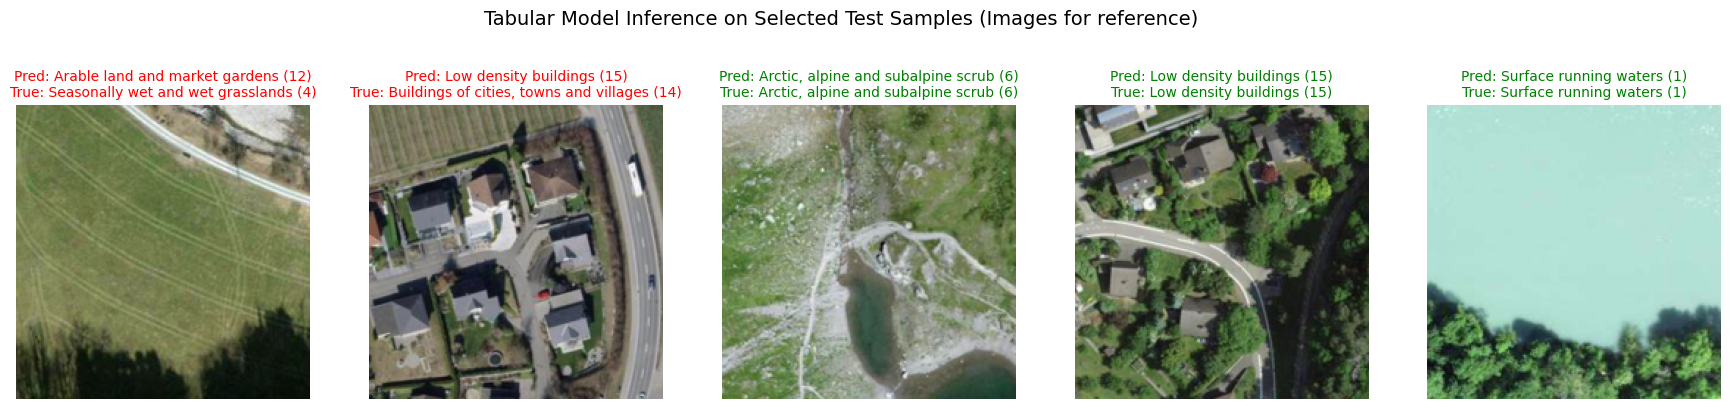

In [7]:
# Create a mapping from class number to label
num_to_label = dict(zip(test_df['EUNIS_cls'], test_df['EUNIS_label']))

num_samples = len(sample_indices)
fig, axes = plt.subplots(1, num_samples, figsize=(22, 5))

for i, ax in enumerate(axes):
    img = load_image_from_folder("data/images_png", image_sample_ids[i])
    ax.imshow(img)

    # Numeric labels
    pred_num = preds[i]
    true_num = true_labels[i]            

    # Map numeric to names
    pred_name = num_to_label.get(pred_num, f"Class {pred_num}")
    true_name = num_to_label[true_num]

    # Overlay predictions with color
    correct = pred_num == true_num
    color = "green" if correct else "red"

    ax.set_title(f"Pred: {pred_name} ({pred_num})\nTrue: {true_name} ({true_num})",
                 color=color, fontsize=10)
    ax.axis("off")

plt.suptitle("Tabular Model Inference on Selected Test Samples (Images for reference)", fontsize=14)
plt.show()